# Profile & Project Details 





1.   Name: Iva Raudyatuzzahra
2.   Email: ivaraudya@gmail.com
3.   Project: News Category Classification
4.   Dataset: https://www.kaggle.com/rmisra/news-category-dataset



# Data Preparation

Mounting google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


File loading

In [5]:
import zipfile

file_zip = '/content/drive/MyDrive/Datasets/news.zip'
zip_extract = zipfile.ZipFile(file_zip, 'r')
zip_extract.extractall('/content/news_data')
zip_extract.close()

Removing unecessary columns

In [6]:
import pandas as pd

df = pd.read_json('/content/news_data/News_Category_Dataset_v2.json', lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [7]:
df.drop(['authors', 'link', 'short_description', 'date'], axis=1, inplace=True)
df.sample()

,category,headline
172477,WELLNESS,How To Eat For Your Age


Removing unecessary categories

In [8]:
df.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [9]:
df = df[~df['category'].isin(['POLITICS','ENTERTAINMENT','WELLNESS','TRAVEL','STYLE & BEAUTY','PARENTING','HEALTHY LIVING', 
                              'QUEER VOICES','FOOD & DRINK','COMEDY','BLACK VOICES','HOME & LIVING','PARENTS','THE WORLDPOST',
                              'WEDDINGS','WOMEN','IMPACT','DIVORCE','MEDIA','WEIRD NEWS','GREEN','WORLDPOST','RELIGION',
                              'STYLE','WORLD NEWS','TASTE','MONEY','ARTS','FIFTY','GOOD NEWS','ARTS & CULTURE','COLLEGE',
                              'LATINO VOICES','CULTURE & ARTS','SCIENCE','SCIENCE','EDUCATION'])]
df['category'].value_counts()

BUSINESS       5937
SPORTS         4884
CRIME          3405
TECH           2082
ENVIRONMENT    1323
Name: category, dtype: int64

Missing Values Checking

In [10]:
df.isnull().values.any()

False

Data plotting

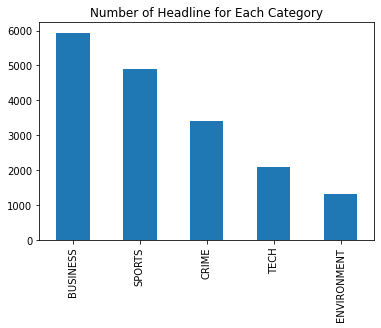

In [11]:
import matplotlib.pyplot as plt
 
df['category'].value_counts().plot(kind='bar')
plt.title('Number of Headline for Each Category')
plt.show()

# Data Preprocessing

data cleaning

In [15]:
import re
import nltk
from nltk.corpus import stopwords

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['headline'] = df['headline'].apply(clean_text)
df['headline'] = df['headline'].str.replace('\d+', '')

In [16]:
df.head()

,category,headline
0,CRIME,mass shootings teas last week tv
1,CRIME,rachel dolezal faces felony charges welfare fraud
2,CRIME,man faces charges pulling knife stun gun musli...
3,CRIME,people injured indiana school shooting
4,SPORTS,jets chairman christopher johnson wont fine pl...


data tokenization

In [18]:
from keras.preprocessing.text import Tokenizer

max_words = 50000
max_seq = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['headline'])
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))


Found 19250 unique tokens.


In [20]:
from keras.preprocessing import sequence

data = tokenizer.texts_to_sequences(df['headline'])
data = sequence.pad_sequences(data, maxlen=max_seq)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (17631, 250)


In [21]:
label = pd.get_dummies(df['category']).values
print('Shape of label tensor:', label.shape)

Shape of label tensor: (17631, 5)


data spliting

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_test, label_train, label_test = train_test_split(data,label, test_size = 0.20, random_state = 42)
print(data_train.shape,label_train.shape)
print(data_test.shape,label_test.shape)

(14104, 250) (14104, 5)
(3527, 250) (3527, 5)


# Classification Model Building

Importing library & module

In [24]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

LSTM model

In [31]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=data.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


Lost function & optimizer

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stopping

In [33]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
      print("\nValidation accuracy has reach 90%, training has been stopped.")
      self.model.stop_training = True
callbacks = myCallback()

Model training

In [34]:
history = model.fit(data_train, label_train, 
                    epochs=5, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose=2,
                    callbacks= callbacks)

Epoch 1/5
177/177 - 164s - loss: 1.1365 - accuracy: 0.5604 - val_loss: 0.7208 - val_accuracy: 0.7366
Epoch 2/5
177/177 - 160s - loss: 0.4368 - accuracy: 0.8537 - val_loss: 0.5655 - val_accuracy: 0.8047
Epoch 3/5
177/177 - 160s - loss: 0.1790 - accuracy: 0.9475 - val_loss: 0.6038 - val_accuracy: 0.8072
Epoch 4/5
177/177 - 160s - loss: 0.0777 - accuracy: 0.9775 - val_loss: 0.7099 - val_accuracy: 0.7969
Epoch 5/5
177/177 - 161s - loss: 0.0394 - accuracy: 0.9892 - val_loss: 0.8467 - val_accuracy: 0.7983


Validation & Training Accurary Plotting

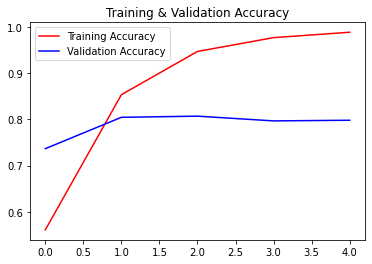

<Figure size 432x288 with 0 Axes>

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()